**Name:**

**Collaborator(s):**


# Studio 11 - The Folk Theorem

Gelman's [Folk Theorem of Statistical Computing](https://statmodeling.stat.columbia.edu/2008/05/13/the_folk_theore/) states

> _"When you have computational problems, often there’s a problem with your model."_

This principle means that computational difficulties (slow convergence, sensitivity to initialization, getting stuck in local optima) can reflect genuine statistical issues (weak identifiability, overparameterization, insufficient data). Today we will see an example of this; along the way, we'll practice making an algorithm more efficient and numerically stable.

### Defining a Gaussian Mixture Model

A Gaussian Mixture Model (GMM) represents data as coming from a mixture of $K$ Gaussian distributions. The density of a GMM has the form:
$$p(\mathbf{x}) = \sum_{k=1}^K\pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k),$$
where
- $\pi_k$ are mixing proportions (with $\pi_k\ge 0$ and $\sum_{k=1}^K\pi_k = 1$)
- $\boldsymbol{\mu}_k \in \mathbb{R}^d$ are component means
- $\boldsymbol{\Sigma}_k \in \mathbb{R}^{d\times d}$ are component covariance matrices (must be positive definite)

We have a sample of observations $(x_i)_{i=1}^n$ and wish to estimate the parameters of the GMM.

### Latent Variable Interpretation

If $x_i$ is drawn from the GMM $p$, we can introduce a latent variable $z_i \in {1, 2, ..., K}$ that indicates which Gaussian distribution $\mathbf{x}_i$ came from, i.e.
- $p(z_i = k) = \pi_k$ (prior probability of component k)
- $p(\mathbf{x}_i | z_i = k) = \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ (likelihood given component)

If we knew the $z_i$ values, parameter estimation would be easy: just compute sample means and covariances for each group! Since we don't know them, the _EM algorithm_ alternates between inferring the latent assignments and updating the parameters as if those inferred assignments were correct.

## The EM Algorithm

EM alternates between two steps:
### E-Step (Expectation)

Compute the posterior "responsibility" that component $k$ takes for observation $i$:
$$\gamma_{ik} = p(z_i = k | \mathbf{x}_i) = \frac{\pi_k \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$
Responsibilities are soft cluster assignments: each point belongs partially to each component.

### M-Step (Maximization)

Update parameters using the weighted data:
- **Mixing proportions:** $\pi_k = \frac{1}{n} \sum_{i=1}^n \gamma_{ik}$
- **Means:** $\boldsymbol{\mu}_k = \frac{\sum_{i=1}^n \gamma_{ik} \mathbf{x}_i}{\sum_{i=1}^n \gamma_{ik}}$
- **Covariances:** $\boldsymbol{\Sigma}_k = \frac{\sum_{i=1}^n \gamma_{ik} (\mathbf{x}_i - \boldsymbol{\mu}_k)(\mathbf{x}_i - \boldsymbol{\mu}_k)^T}{\sum_{i=1}^n \gamma_{ik}}$
### Algorithm Summary

Initialize parameters $\theta^{(0)} = (\pi^{(0)}, \mu^{(0)}, \Sigma^{(0)})$ randomly

Repeat:
-  E-step: compute responsibilities $\gamma^{(t+1)}$ given $\theta^{(t)}$
-  M-step: update $\theta^{(t+1)}$ using responsibilities $\gamma^{(t+1)}$

**Convergence criterion**: Stop when the log-likelihood change is smaller than some threshold $\varepsilon$, or when some maximum number of iterations has been reached.

In [1]:
import numpy as np
import pandas as pd
from naive_em_algorithm import GaussianMixtureModel

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
plt.rcParams.update({
    'lines.linewidth' : 1.,
    'lines.markersize' : 5,
    'font.size': 9,
    "text.usetex": True,
    'font.family': 'serif', 
    'font.serif': ['Computer Modern'],
    'text.latex.preamble' : r'\usepackage{amsmath,amsfonts}',
    'axes.linewidth' : .75})

from time import time

## Exercise 1: Vectorize the EM Algorithm

Explore the implementation of the EM Algorithm in `naive_em_algorithm.py`. Then, implement your own class, called `GaussianMixtureModelVectorized`, in the file `vectorized_em_algorithm.py`. Your code should be at least 100 times faster than the naive implementation on the example below.


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

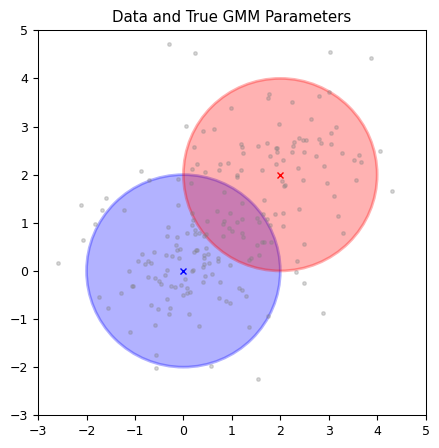

In [2]:
n_components = 2
pi = np.ones(n_components) / n_components
mus = [np.array([0., 0.]), np.array([2., 2.])]
covs = [np.eye(2)]*2

DGP = GaussianMixtureModel(random_state=1234567891)
DGP._set_parameters(mus, covs, pi)

n_samples = 200
X, Z = DGP.sample(n_samples)

plt.rcParams['text.usetex'] = False
plt.figure(figsize=(5,5))
plt.plot(X[:,0], X[:, 1], '.', color='gray', alpha=.3)
DGP.plot_2D_model(plt.gca(), 'br')
plt.title('Data and True GMM Parameters')
plt.xlim([-3, 5])
plt.ylim([-3, 5])
plt.show()

In [3]:
t0 = time()
indices = np.random.choice(n_samples, n_components, replace=False)
initial_theta = [[X[i].copy() for i in indices],
    [np.eye(2) for _ in range(n_components)],
    np.ones(n_components) / n_components]
GMM = GaussianMixtureModel()
GMM.fit(X, initial_theta=initial_theta)
t1 = time()
naive_time = t1-t0

 16%|█▋        | 82/500 [00:02<00:11, 35.82it/s]


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

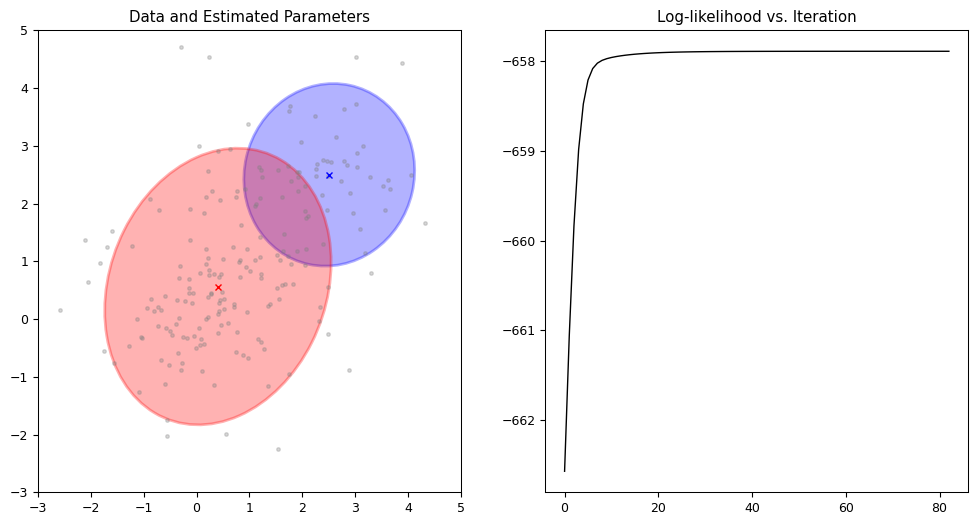

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(X[:,0], X[:, 1], '.', color='gray', alpha=.3)
GMM.plot_2D_model(axs[0], 'br')
axs[0].set_title('Data and Estimated Parameters')
axs[0].set_xlim([-3, 5])
axs[0].set_ylim([-3, 5])

axs[1].plot(GMM.log_likelihoods_, c='k')
axs[1].set_title('Log-likelihood vs. Iteration')
plt.show()

In [5]:
# TO DO: implement this before running!
from vectorized_em_algorithm import GaussianMixtureModelVectorized

t0 = time()
GMM2 = GaussianMixtureModelVectorized()
GMM2.fit(X, initial_theta=initial_theta)
t1 = time()
vectorized_time = t1-t0

print(f"Vectorized code was {naive_time / vectorized_time:.2f} times faster!")

 16%|█▋        | 82/500 [00:00<00:00, 2565.38it/s]

Vectorized code was 68.88 times faster!


In [6]:
assert np.allclose(GMM.mu_, GMM2.mu_)

## Exercise 2: Make the Method Numerically Stable

Recall from lecture that the normalizing constant $\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)$ in the responsibilities can be very small if $\mathbf{x}_i$ is far from every cluster. This leads to divide by zero errors in the E-step.

Implement the log-sum-exp trick in `GaussianMixtureModelVectorized` to compute both the responsibilities in `_e_step` and the log-likelihood in `_compute_log_likelihood`. These will both be necessary for Exercise 3.

In [7]:
n_features = 50
n_components = 2
pi = np.ones(n_components) / n_components
covs = [np.eye(n_features)]*2

for scale in [.5, 1, 5, 50]:
    mus = [-scale*np.random.rand(n_features), scale*np.random.rand(n_features)]

    DGP = GaussianMixtureModel(random_state=1234567891)
    DGP._set_parameters(mus, covs, pi)

    n_samples = 200
    X, Z = DGP.sample(n_samples)

    GMM = GaussianMixtureModel()
    GMM2 = GaussianMixtureModelVectorized()

    GMM._set_parameters([np.zeros(n_features)]*2, covs, pi)
    GMM2._set_parameters([np.zeros(n_features)]*2, covs, pi)
    print(GMM.score(X), GMM2.score(X))

-14614.552249534281 -14614.552249534276
-15917.05789822077 -15917.057898220759
-52453.84406547207 -52453.84406547207
-138155.10557964235 -3880250.471634754


## Exercise 3: Document the Folk Theorem

The model identifiability of a GMM depends on the cluster separation, e.g. $\|\mu_1-\mu_2\|$. When mixture components are harder to distinguish statistically (small separation), the Folk Theorem suggests EM will run into a range of problems:
- More iterations/more time to converge (slow convergence)
- Higher variance in convergence time across initializations (sensitivity to initialization)
- Greater sensitivity e.g. in final log-likelihood to random initialization (getting stuck in local optima)

Generate datasets with varying separations, run EM multiple times (e.g. 20-30 runs) at each separation with different random initializations, and plot each of these metrics as a function of separation.

In [8]:
def generate_data_with_separation(separation, n_samples=200, n_features=2, random_state=None):
    """
    Generate 2D data from two Gaussian components with specified separation.
    
    Parameters
    ----------
    separation : float
        Distance between component means (Euclidean distance)
    n_samples : int, default=200
        Total number of samples to generate
    n_features : int, default=2
        Dimensionality
    random_state : int or None, default=None
        Random seed for reproducibility
    
    Returns
    -------
    X : array, shape (n_samples, 2)
        Generated data points
    true_labels : array, shape (n_samples,)
        True component assignments (0 or 1)
    """
    # Create a GMM with known parameters
    DGP = GaussianMixtureModelVectorized(n_components)
    
    # Set true parameters manually
    mu1 = np.zeros(n_features)
    mu2 = separation * np.ones(n_features) / np.sqrt(n_features)
    
    cov = np.eye(n_features)
    
    DGP.mu_ = np.array([mu1, mu2])
    DGP.cov_ = np.array([cov]*2)
    DGP.pi_ = np.array([0.5, 0.5])
    
    # Sample from the GMM
    X, Z = DGP.sample(n_samples=n_samples, random_state=random_state)
    
    return X, Z

In [9]:
def run_folk_theorem_experiment(separations, n_runs=30, n_samples=200, n_features=2, max_iter=500):
    """
    For each separation value from separations list, fit GMM multiple (n_runs=30) times with different random initializations
    and track convergence metrics.

    Parameters
    ----------
    separations : array-like
        List of separation values to test
    n_runs : int, default=30
        Number of random initializations per separation
    n_samples : int, default=200
        Number of samples to generate
    n_features : int, default=2
        Dimensionality of the data
    max_iter : int, default=500
        Maximum number of EM iterations

    Returns
    -------
    results : pandas.DataFrame
        DataFrame containing metrics for each run
    """
    results = []

    for sep in separations:
        print(f"\nTesting separation = {sep:.4f}")

        # Generate data with this separation
        X, Z = generate_data_with_separation(sep, n_samples, n_features, random_state=42)

        for run in range(n_runs):
            # Fit GMM with different random initialization
            gmm = GaussianMixtureModelVectorized(n_components=2, random_state=run)

            start_time = time()
            gmm.fit(X, max_iter=max_iter, tol=1e-6, verbose=False)
            elapsed_time = time() - start_time

            # Record metrics
            results.append({
                'separation': sep,
                'run': run,
                'n_iterations': gmm.n_iter_,
                'converged': gmm.converged_,
                'final_log_likelihood': gmm.log_likelihoods_[-1],
                'time_seconds': elapsed_time
            })

    return pd.DataFrame(results)

In [10]:
# Run the experiment with different separation values
separations = np.geomspace(1e-3, 5.0, 12)
n_components = 2

results_df = run_folk_theorem_experiment(separations, n_runs=25)
print("\nExperiment complete!")
print(results_df.head())


Testing separation = 0.0010

Testing separation = 0.0022

Testing separation = 0.0047

Testing separation = 0.0102

Testing separation = 0.0221

Testing separation = 0.0480

Testing separation = 0.1041

Testing separation = 0.2259

Testing separation = 0.4900

Testing separation = 1.0627

Testing separation = 2.3052

Testing separation = 5.0000

Experiment complete!
   separation  run  n_iterations  converged  final_log_likelihood  \
0       0.001    0           479       True           -563.672857   
1       0.001    1           248       True           -564.028345   
2       0.001    2           344       True           -564.028345   
3       0.001    3           151       True           -564.028346   
4       0.001    4           343       True           -564.028346   

   time_seconds  
0      0.157732  
1      0.078576  
2      0.105556  
3      0.046563  
4      0.108184  


In [11]:
# Compute summary statistics for each separation
summary = results_df.groupby('separation').agg({
    'n_iterations': ['mean', 'std'],
    'time_seconds': ['mean', 'std'],
    'final_log_likelihood': ['mean', 'std'],
    'converged': 'sum'
}).round(3)

print("\nSummary Statistics:")
print(summary)


Summary Statistics:
           n_iterations          time_seconds        final_log_likelihood  \
                   mean      std         mean    std                 mean   
separation                                                                  
0.001000         332.60  122.555        0.107  0.040             -563.915   
0.002169         332.80  122.646        0.108  0.040             -563.909   
0.004705         333.48  122.948        0.103  0.038             -563.897   
0.010205         334.40  123.139        0.104  0.039             -563.871   
0.022135         336.28  123.060        0.112  0.042             -563.820   
0.048012         339.76  124.173        0.106  0.039             -563.730   
0.104141         355.76  113.816        0.112  0.035             -563.659   
0.225886         332.60  111.150        0.103  0.035             -564.008   
0.489959         294.20  117.278        0.093  0.037             -566.678   
1.062747         283.96  150.626        0.088  0.047   

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.rcParams['text.usetex'] = False

# Plot 1: Number of iterations vs separation
ax = axes[0, 0]
summary_iters = results_df.groupby('separation')['n_iterations'].agg(['mean', 'std']).sort_index()
ax.errorbar(summary_iters.index, summary_iters['mean'],
            yerr=summary_iters['std'], marker='o', capsize=5, linewidth=2, color='orange')
ax.set_xscale('log')
ax.set_xlabel('Separation (log scale)')
ax.set_ylabel('Number of iterations to converge')
ax.set_title('Convergence Speed vs. Separation')
ax.grid(True, which='both', alpha=0.3)

# Plot 2: Computation time vs separation
ax = axes[0, 1]
summary_time = results_df.groupby('separation')['time_seconds'].agg(['mean', 'std']).sort_index()
ax.errorbar(summary_time.index, summary_time['mean'],
            yerr=summary_time['std'], marker='o', capsize=5, linewidth=2, color='green')
ax.set_xscale('log')
ax.set_xlabel('Separation (log scale)')
ax.set_ylabel('Time to converge (seconds)')
ax.set_title('Computation Time vs. Separation')
ax.grid(True, which='both', alpha=0.3)

# Plot 3: Std of iterations (sensitivity to initialization)
ax = axes[1, 0]
ax.plot(summary_iters.index, summary_iters['std'], marker='o', linewidth=2, color='red')
ax.set_xscale('log')
ax.set_xlabel('Separation (log scale)')
ax.set_ylabel('Std. dev. of iterations')
ax.set_title('Sensitivity to Initialization (Iterations)')
ax.grid(True, which='both', alpha=0.3)

# Plot 4: Std of final log-likelihood (local optima)
ax = axes[1, 1]
summary_ll = results_df.groupby('separation')['final_log_likelihood'].agg(['mean', 'std']).sort_index()
ax.plot(summary_ll.index, summary_ll['std'], marker='o', linewidth=2, color='blue')
ax.set_xscale('log')
ax.set_xlabel('Separation (log scale)')
ax.set_ylabel('Std. dev. of final log-likelihood')
ax.set_title('Sensitivity to Local Optima')
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig('folk_theorem_results.png', dpi=150, bbox_inches='tight')
plt.show()


PANIC: unprotected error in call to Lua API (zlib library version does not match - header: 1.2.13, library: 1.3)


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmr9.tfm' in your texmf tree, but could not find it

PANIC: unprotected error in call to Lua API (zlib library version does not match - header: 1.2.13, library: 1.3)


Error in callback <function _draw_all_if_interactive at 0x10de8de40> (for post_execute), with arguments args (),kwargs {}:


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmr9.tfm' in your texmf tree, but could not find it

PANIC: unprotected error in call to Lua API (zlib library version does not match - header: 1.2.13, library: 1.3)


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmr9.tfm' in your texmf tree, but could not find it

<Figure size 1200x1000 with 4 Axes>